In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# **Function Details**
***load_dataset***: Loads sentences and labels from a text file, optionally joining words into strings.

***get_unique_tags***: Extracts unique tags (e.g., LOCATION, NAME) from the file.

***get_tokens_labels_spans***: Splits sentences into tokens, labels, and character spans.

***build_display_elements***: Formats data for visualization (e.g., spaCy’s displacy) with entity spans.

***convert_cell_to_tag***: Extracts tags from error analysis tuples.

***convert_string_to_list***: Parses stringified lists from CSV cells.

***get_indexes_of_filtered_errors***: Finds sentence indices with specific errors (e.g., No Extraction) and tags (e.g., LOCATION) from a CSV.

In [101]:
colors = {
        'DATE': '#EA2F86',  # https://www.schemecolor.com/bright-rainbow-gradient.php
        'GENDER': '#F09C0A',
        'JOB': '#FAE000',
        'LOCATION': '#93E223',
        'NAME': '#4070D3',
        'O': '#7B7D70',  # gray at https://www.schemecolor.com/rural-stay.php
        'ORGANIZATION': '#493C9E',
        'PATIENT_ID': '#ED3D07',  # red at https://www.schemecolor.com/bright-summer-beach.php
        'SYMPTOM_AND_DISEASE': '#F2E8D8',  # https://www.schemecolor.com/pastels-for-men.php
        'TRANSPORTATION': '#C4A69B'}


def load_dataset(filepath, concatenate_words=False):
    """
    Load the dataset from the text file
    :param concatenate_words: whether to keep the sample as a single string instance or a list of words
    :param filepath: path to the .txt file
    :return: sentences, labels
    """
    with open(filepath, encoding='utf8') as f:
        lines = []
        for line in f:
            lines.append(line.replace('\n', ''))

    sentences = []
    labels = []

    words = []
    label = []
    for line in lines:
        if len(line.split()) < 2:
            if concatenate_words:
                sentences.append(' '.join(words))
                labels.append(' '.join(label))
            else:
                sentences.append(words)
                labels.append(label)
            words = []
            label = []
        else:
            words.append(line.split()[0])
            label.append(line.split()[1])

    return sentences, labels


def get_unique_tags(filepath):
    """
    Get all unique tags that are present in one .txt file
    :param filepath: path to the .txt file
    :return: list of tags
    """
    with open(filepath, encoding='utf8') as f:
        lines = []
        for line in f:
            lines.append(line.replace('\n', ''))

    all_tags = set()
    for line in lines:
        if len(line.split()) == 2:
            tag = line.split()[1].replace('B-', '').replace('I-', '')  #ignore B- and I-
            all_tags.add(tag)

    return list(all_tags)


def get_tokens_labels_spans(sentences, labels):
    """ for visualisation
    Get all tokens, labels, spans from a specific list of sentences and labels
    :param sentences: list of sentences, each sentence is a string
    :param labels: list of labels (tags) of the corresponding sentence, each label of a string is also in the string format
    :return: list of tokens, list of labels, list of spans
    """
    all_tokens = []
    all_labels = []
    all_spans = []
    for i in range(len(sentences)):
        hi = sentences[i]
        ho = labels[i]
        span = []
        last_position = 0
        for index, char in enumerate(hi):
            if char == " ":
                span.append([last_position, index])
                last_position = index + 1
        span.append([last_position, index])

        annotation = ho.split()
        tokens = hi.split()

        all_tokens.append([tokens])
        all_labels.append([annotation])
        all_spans.append([span])
    return all_tokens, all_labels, all_spans


def build_display_elements(tokens, annotations, spans):
    # convert the annotations to the format used in displacy
    all_ann = []

    for sent_id, sent_info in enumerate(tokens):
        sent_length = len(tokens[sent_id])

        last_ann = 'O'
        last_start = None
        last_end = None
        for token_id in range(sent_length):
            this_ann = annotations[sent_id][token_id]

            # separated cases:
            if this_ann != last_ann:
                if last_ann != 'O':
                    # write last item
                    new_ent = {}
                    new_ent['start'] = last_start
                    new_ent['end'] = last_end
                    new_ent['label'] = last_ann[2:]
                    all_ann.append(new_ent)

                # record this instance
                last_ann = 'O' if this_ann == 'O' else 'I' + this_ann[1:]
                last_start = spans[sent_id][token_id][0]
                last_end = spans[sent_id][token_id][1]

            else:
                last_ann = this_ann
                last_end = spans[sent_id][token_id][1]

        if last_ann != 'O':
            new_ent = {}
            new_ent['start'] = last_start
            new_ent['end'] = last_end
            new_ent['label'] = last_ann[2:]
            all_ann.append(new_ent)
    return all_ann


errors = ['No Extraction', 'No Annotation', 'Wrong Tag', 'Wrong Range', 'Wrong Range and tag', 'Num correct tags']
PICK_AN_ERROR_INDEX = 0  # 0 means No Extraction and so on.
PICK_A_GOLD_TAG = 'None'  # Set to None to view all tags


def convert_cell_to_tag(cell):
    """
    Convert each cell of the dataframe to list of tags
    :param cell: List of tuples, each tuple has 2 lists: 1 contains words, the other contains labels
    :return: List of list, each inner list contains, labels from corresponding tuple of the input cell
    """
    tags = []
    for my_tuple in cell:
        tag = list(set(word.replace('B-', '').replace('I-', '') for word in my_tuple[0]))
        tags.append(tag[0])
    return tags


def convert_string_to_list(cell):
    """
    Cells of the imported result file are not interpreted as lists, so each cell has to be manually converted into a list
    :param cell: cell in which the string content can be casted to list
    :return: list
    """
    return ast.literal_eval(cell)


def get_indexes_of_filtered_errors(ERROR_TYPE_DF_PATH, PICK_AN_ERROR, PICK_A_GOLD_TAG):
    """
    :param ERROR_TYPE_DF_PATH: path to the error analysis table file
    :param PICK_AN_ERROR: choose one error in list of errors
    :param PICK_A_GOLD_TAG: choose one tag
    :return: return a list of indices of sentences that have PICK_A_GOLD_TAG tag and have fallen in to an error type
    """

    def count_tag_in_cell(cell):
        if PICK_A_GOLD_TAG == None:
            return len(cell)
        return len([tag for tag in cell if tag == PICK_A_GOLD_TAG])

    df3 = pd.read_csv(ERROR_TYPE_DF_PATH)
    df3 = df3.iloc[:, :-1]

    for error in errors:
        df3[error] = df3[error].map(convert_string_to_list)
        df3[error] = df3[error].map(convert_cell_to_tag)

    df3['Error Counts'] = df3[PICK_AN_ERROR].map(count_tag_in_cell)

    indexes = []
    for i, row in df3.iterrows():
        if row['Error Counts'] != 0:
            indexes.append(i)
    return indexes

# **Create the the error details from test prediction of BiLSTM-CNN-CRF**

We will do some error analysis on the BiLSTM-CNN-CRF F and PhoBERT by extracting errors after these models have clasified the tags into test set.
we will compare from the ground truth base which are given by VinAI (test_true_bilstm.txt) and the predictions whose the models made
 (test_predictions_bilstm.txt)

**there are 5 categories**:
1. No Extraction (mô hình không nhận diện được thực thể, nghĩa là nhận thực thể thành 'O' trong khi ground truth là 1 trong 10 tag)
2. No Annotation (mô hình gán nhãn là thực thể dù ground truth không phải thực thể ('O') )
3. Wrong Range (nhận diện đúng thực thể, nhưng vị trí bắt đầu, kết thúc của tag (B-, I-) bị sai)
4. Wrong Tag (gán sai nhãn, vd: LOCATION trong ground truth bị gán thành LOCATION trong prediction)
5. Wrong Range and Tag (vừa sai phạm vi, vừa sai nhãn)

**ErrorTypesGold is the main function addressing errors for each fault**:
1. self._get_span_of(tags)  -> determine span that has B-xxx, I-xxx.
2. check() -> iterate over each entity in the ground truth base, then compare:
3. Did model do predictions?
4. If yes, was the range precise?
5. Was every tag right?
6. Detect lack of entity -> No Extraction
7. If model had tagged some redundant tags (nhãn mà ground truth không có) -> No Annotation
8. Other wrong tagging -> assign to the suitable categories respectively.

**Tổng hợp lỗi theo câu**:
df = pd.DataFrame(columns=errors)
...
df.to_csv('df_error_types_bilstm_gold.csv')
Mỗi hàng tương ứng với một câu. Mỗi cột chứa danh sách lỗi thuộc loại đó.

**Thống kê loại lỗi theo tag**:
df2 = pd.DataFrame(columns=errors)
Tính số lần mỗi loại lỗi xảy ra theo từng tag, ví dụ:
	LOCATION bị gán sai nhãn bao nhiêu lần?, AGE bị bỏ sót bao nhiêu lần?
-> biết thực thể nào model đang làm tốt hoặc kém.



*   df_error_types_bilstm_gold.csv: lỗi chi tiết cho từng câu (để debug cụ thể)
*   df_error_types_bilstm_gold_summary.csv: thống kê lỗi tổng quát






In [102]:

class ErrorTypesGold:
    def __init__(self, tags_true, tags_pred, words_true, words_pred):
        self.result = {'No Extraction': [], 'No Annotation': [], 'Wrong Tag': [], 'Wrong Range': [], 'Wrong Range and tag': [], 'Num correct tags': []}
        self.tags_true = tags_true
        self.tags_pred = tags_pred
        self.words_true = words_true
        self.words_pred = words_pred
        self.spans_tags_true, self.spans_O_tags_true = self._get_span_of(tags_true)
        self.spans_tags_pred, self.spans_O_tags_pred = self._get_span_of(tags_pred)

    def _get_span_of(self, tags):
        entities = []
        single_entity = []

        for i, tag in enumerate(tags):
            if 'I-' in tag:
                single_entity.append(i)
            elif single_entity:
                if tag == 'O':
                    entities.append(single_entity)
                    single_entity = []
                elif 'B-' in tag:
                    entities.append(single_entity)
                    single_entity = [i]
            elif 'B-' in tag:
                single_entity.append(i)
        if single_entity:
            entities.append(single_entity)

        empty_spans = []
        empty_span = []

        for i, tag in enumerate(tags):
            if not empty_span and tag == 'O':
                empty_span.append(i)
            elif not any(x in tag for x in ['B-', 'I-']):
                empty_span.append(i)
            elif empty_span and any(x in tag for x in ['B-', 'I-']):

                empty_spans.append(empty_span)
                empty_span = []
        if empty_span:
            empty_spans.append(empty_span)

        return entities, empty_spans

    def _get_tags_true_in(self, span, exclude_o_tag=False):
        start, end = span[0], span[-1] + 1
        tags = self.tags_true[start: end]
        if exclude_o_tag:
            tags = list(set(word.replace('B-', '').replace('I-', '') for word in tags if word != 'O'))
        else:
            tags = list(set(word.replace('B-', '').replace('I-', '') for word in tags))
        return tags

    def _get_tags_pred_in(self, span, exclude_o_tag=False):
        start, end = span[0], span[-1] + 1
        tags = self.tags_pred[start: end]
        if exclude_o_tag:
            tags = list(set(word.replace('B-', '').replace('I-', '') for word in tags if word != 'O'))
        else:
            tags = list(set(word.replace('B-', '').replace('I-', '') for word in tags))
        return tags

    def _is_correct_range(self, span):
        return span in self.spans_tags_pred

    def _is_overlap(self, span, with_O_spans_tags_true=False):

        if not with_O_spans_tags_true:
            for that_span in self.spans_tags_pred:
                if len([bound for bound in span if bound in that_span]) == len(span):
                    return False
        else:
            for that_span in self.spans_O_tags_true:
                if len([bound for bound in span if bound in that_span]) == len(span):
                    return False

        return True

    def check(self):
        for span in self.spans_tags_true:
            start, end = span[0], span[-1] + 1
            tags_pred = self._get_tags_pred_in(span)
            tags_true = self._get_tags_true_in(span)
            raw_tag_true = self.tags_true[start: end]
            raw_tag_pred = self.tags_pred[start: end]
            raw_tag_true_to_end = self.tags_true[start:]
            raw_tag_pred_to_end = self.tags_pred[start:]
            raw_words = self.words_true[start: end]

            if self._is_correct_range(span):
                if tags_pred != tags_true:
                    self.result['Wrong Tag'].append((raw_tag_true, raw_tag_pred, raw_words))
                elif tags_pred == ['O'] * len(tags_pred):
                    self.result['No Extraction'].append((raw_tag_true, raw_tag_pred, raw_words))
                else:
                    self.result['Num correct tags'].append((raw_tag_true, raw_tag_pred, raw_words))
            else:
                if self._is_overlap(span):
                    if raw_tag_pred == ['O'] * len(raw_tag_pred):
                        self.result['No Extraction'].append((raw_tag_true, raw_tag_pred, raw_words))
                    elif tags_true[0] in tags_pred:
                        if 'O' in tags_pred:
                            self.result['Wrong Range'].append((raw_tag_true, raw_tag_pred, raw_words))
                        elif len([tag for tag in raw_tag_pred if 'B-' in tag]) != 1:
                            self.result['Wrong Range'].append((raw_tag_true, raw_tag_pred, raw_words))
                        elif len(raw_tag_pred) >= end + 1 and 'I-' in raw_tag_pred[end]:
                            self.result['Wrong Range'].append((raw_tag_true, raw_tag_pred, raw_words))

                    else:
                        self.result['Wrong Range and tag'].append((raw_tag_true, raw_tag_pred, raw_words))  # print(raw_tag_true, raw_tag_pred, raw_words, sep='\n')  # print(raw_tag_true_to_end)  # print(raw_tag_pred_to_end)  # print('---------------')

                else:
                    if len([tag for tag in raw_tag_pred if 'B-' in tag]) != 1:
                        if tags_true[0] in tags_pred:
                            self.result['Wrong Range'].append((raw_tag_true, raw_tag_pred, raw_words))
                        else:
                            self.result['Wrong Range and tag'].append((raw_tag_true, raw_tag_pred, raw_words))  # print(raw_tag_true, raw_tag_pred, raw_words, sep='\n')  # print(raw_tag_true_to_end)  # print(raw_tag_pred_to_end)  # print('---------------')
                    else:
                        self.result['Num correct tags'].append((raw_tag_true, raw_tag_pred, raw_words))

        for span in self.spans_tags_pred:
            start, end = span[0], span[-1] + 1
            tags_pred = self._get_tags_pred_in(span)
            tags_true = self._get_tags_true_in(span)
            raw_tag_true = self.tags_true[start: end]
            raw_tag_pred = self.tags_pred[start: end]
            raw_words = self.words_true[start: end]
            if not self._is_overlap(span, with_O_spans_tags_true=True):
                self.result['No Annotation'].append((raw_tag_true, raw_tag_pred, raw_words))

        return self

all_words_true, all_tags_true = load_dataset(r'/content/drive/MyDrive/NLP project/Error Analysis/BiLSTM-CRF analysis/test_true_BiLSTM.txt')
unique_tags = get_unique_tags(r'/content/drive/MyDrive/NLP project/Error Analysis/BiLSTM-CRF analysis/test_true_BiLSTM.txt')
all_words_pred, all_tags_pred = load_dataset(r'/content/drive/MyDrive/NLP project/Error Analysis/BiLSTM-CRF analysis/test_prediction_BiLSTM.txt')

errors = ['No Extraction', 'No Annotation', 'Wrong Range', 'Wrong Tag', 'Wrong Range and tag', 'Num correct tags']
df = pd.DataFrame(columns=errors)

for i, (tags_true, tags_pred, words_true, words_pred) in enumerate(zip(all_tags_true, all_tags_pred, all_words_true, all_words_pred)):
    error_types = ErrorTypesGold(tags_true, tags_pred, words_true, words_pred).check()
    df = pd.concat([df, pd.DataFrame([error_types.result])])

df.reset_index(drop=True, inplace=True)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Row'}, inplace=True)
df = pd.concat([df, pd.DataFrame(data={'Sentence': all_words_true})], axis=1)
df.to_csv('/content/drive/MyDrive/NLP project/Error Analysis/BiLSTM-CRF analysis/df_error_types_bilstm_gold.csv', index=False)

# print summary
for column in df.columns:
    if column in ['Num correct tags', 'Row']:
        continue
    print(column)
    print(df[column].apply(lambda x: len(x) if x else False).sum())

##
df_new = df.iloc[:, :-1].copy()

for error in errors:
    df_new[error] = df_new[error].map(convert_cell_to_tag)

##
# Tao df moi
unique_tags = ['PATIENT_ID', 'NAME', 'AGE', 'GENDER', 'JOB', 'LOCATION', 'ORGANIZATION', 'SYMPTOM_AND_DISEASE', 'TRANSPORTATION', 'DATE', 'O']

df2 = pd.DataFrame(columns=errors)
for tag in unique_tags:
    counts = {}
    for error in errors:
        count_tag = lambda x: len([tag_inside for tag_inside in x if tag_inside == tag])
        temp = df_new[error]
        counts[error] = temp.map(count_tag).sum()
    df2 = pd.concat([df2, pd.DataFrame(data=counts, index=[0])])
# count tung truong hop roi gan vao df moi

df2.reset_index(drop=True, inplace=True)
df2 = pd.concat([pd.DataFrame(data={'Tag': unique_tags}), df2], axis=1)

# Tạo cột Errors
num_errors = []
for tag in unique_tags:
    num_errors.append(df2[df2['Tag'] == tag].iloc[:, 1:-1].sum().sum())
df2 = pd.concat([pd.DataFrame(data={'Errors': num_errors}), df2], axis=1)

# tạo cột total
totals = []
for tag in unique_tags:
    totals.append(df2[df2['Tag'] == tag].iloc[:, 2:].sum().sum())
df2 = pd.concat([pd.DataFrame(data={'Total': totals}), df2], axis=1)

# Sắp xếp lại
df2 = df2[['Tag', 'Total', 'Errors', 'No Extraction', 'No Annotation', 'Wrong Range', 'Wrong Tag', 'Wrong Range and tag']]

# Tạo hàng Total
total_row = df2.sum(axis=0).to_dict()
total_row['Tag'] = 'Total'
df2 = pd.concat([df2, pd.DataFrame(total_row, index=[0])])

df2.to_csv('/content/drive/MyDrive/NLP project/Error Analysis/BiLSTM-CRF analysis/df_error_types_bilstm_gold_summary.csv', index=False)  ##


No Extraction
564
No Annotation
251
Wrong Range
330
Wrong Tag
156
Wrong Range and tag
61
Sentence
85678


# **BiLSTM-CNN-CRF errors extracting** #

In [103]:
df_final_bi = pd.read_csv("/content/drive/MyDrive/NLP project/Error Analysis/BiLSTM-CRF analysis/df_error_types_bilstm_gold_summary.csv")

colors_error_types = {'No Extraction': 'C0',
                      'No Annotation': 'C1',
                      'Wrong Range': 'C2',
                      'Wrong Tag': 'C3',
                      'Wrong Range and tag': 'C4'}

colors = {
        'DATE': '#EA2F86',  # https://www.schemecolor.com/bright-rainbow-gradient.php
        'GENDER': '#F09C0A',
        'JOB': '#FAE000',
        'LOCATION': '#93E223',
        'NAME': '#4070D3',
        'AGE': '#9925be',
        'O': '#7B7D70',  # màu gray ở https://www.schemecolor.com/rural-stay.php
        'ORGANIZATION': '#493C9E',
        'PATIENT_ID': '#ED3D07',  # màu đỏ https://www.schemecolor.com/bright-summer-beach.php
        'SYMPTOM_AND_DISEASE': '#F2E8D8',  # https://www.schemecolor.com/pastels-for-men.php
        'TRANSPORTATION': '#C4A69B'}

In [104]:
df_final_bi

,Tag,Total,Errors,No Extraction,No Annotation,Wrong Range,Wrong Tag,Wrong Range and tag
0,PATIENT_ID,2005,80,44,0,17,16,3
1,NAME,318,66,51,0,4,4,7
2,AGE,582,39,31,0,4,3,1
3,GENDER,462,37,35,0,0,1,1
4,JOB,173,91,74,0,12,4,1
5,LOCATION,4441,336,107,0,167,46,16
6,ORGANIZATION,771,161,42,0,32,65,22
7,SYMPTOM_AND_DISEASE,1136,237,151,0,80,4,2
8,TRANSPORTATION,193,22,5,0,6,6,5
9,DATE,1654,42,24,0,8,7,3


In [105]:
df_all = df_final_bi.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [106]:
df_all

,Tag,Total,Errors,No Extraction,No Annotation,Wrong Range,Wrong Tag,Wrong Range and tag
11,Total,11986,1362,564,251,330,156,61


In [107]:
name = pd.Series(["Wrong Range", 'No Annotation', "No Extraction", "Wrong Tag", "Wrong Range and tag"])
value = df_all.loc[:, name].iloc[0, :]
value

,11
Wrong Range,330
No Annotation,251
No Extraction,564
Wrong Tag,156
Wrong Range and tag,61


In [108]:
labels_withPct = [f'{l}, {float(s) * 100 / (sum(value)):0.1f}%' for l, s in zip(name, value)]
labels_withPct

['Wrong Range, 24.2%',
 'No Annotation, 18.4%',
 'No Extraction, 41.4%',
 'Wrong Tag, 11.5%',
 'Wrong Range and tag, 4.5%']

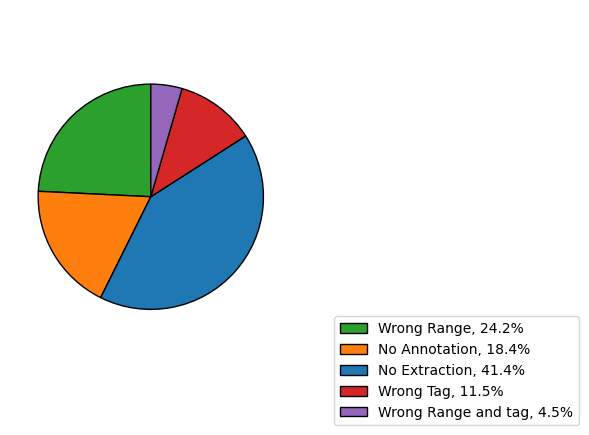

In [109]:
import matplotlib.patches

labels = name.values.tolist()
plt.gca().axis("equal")
pie = plt.pie(list(value), startangle=90, wedgeprops={'linewidth': 1, "edgecolor": "k"},
              colors=[colors_error_types[key] for key in labels])
handles = []

for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i) / 8.), label=l))
plt.legend(labels_withPct, bbox_to_anchor=(1, 0), loc="lower right",
           bbox_transform=plt.gcf().transFigure)
#plt.gcf().text(0.93,0.04,"* out of competition since 2006", ha="right")
#plt.title("Error percentage of No_extraction of PHOBERT",loc="center",fontsize=17)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.54)
plt.savefig('all_error.png', bbox_inches='tight', dpi=300, transparent=True)

# **NO EXTRACTION**

In [110]:
df_noex = df_final_bi[["Tag", "No Extraction"]]
df_noex

,Tag,No Extraction
0,PATIENT_ID,44
1,NAME,51
2,AGE,31
3,GENDER,35
4,JOB,74
5,LOCATION,107
6,ORGANIZATION,42
7,SYMPTOM_AND_DISEASE,151
8,TRANSPORTATION,5
9,DATE,24


In [111]:
df_noex.sort_values("No Extraction", ascending=False, inplace=True, ignore_index=True)
no_ex_sum = df_noex.iloc[0, -1]
df_noex.drop(0, inplace=True)

<ipython-input-111-920349f9ffee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noex.sort_values("No Extraction", ascending=False, inplace=True, ignore_index=True)
<ipython-input-111-920349f9ffee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noex.drop(0, inplace=True)


In [112]:
labelsWithPct = [f'{l}, {s * 100 / (no_ex_sum):0.1f}%' for l, s in zip(df_noex["Tag"], df_noex["No Extraction"])]
labelsWithPct

['SYMPTOM_AND_DISEASE, 26.8%',
 'LOCATION, 19.0%',
 'JOB, 13.1%',
 'NAME, 9.0%',
 'PATIENT_ID, 7.8%',
 'ORGANIZATION, 7.4%',
 'GENDER, 6.2%',
 'AGE, 5.5%',
 'DATE, 4.3%',
 'TRANSPORTATION, 0.9%',
 'O, 0.0%']

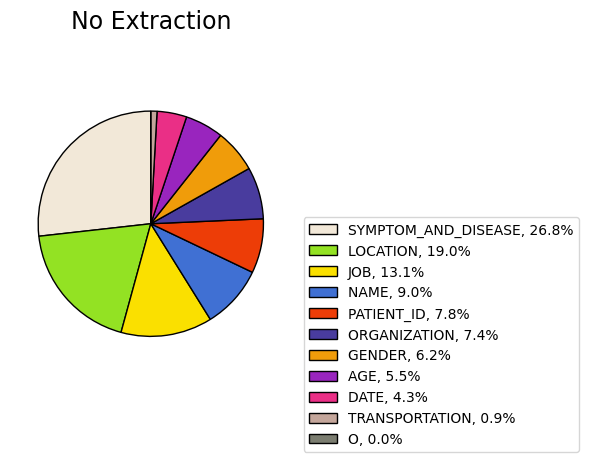

In [113]:
import matplotlib.patches

plt.gca().axis("equal")

temp_labels = df_noex['Tag'].values.tolist()
pie = plt.pie(df_noex["No Extraction"], startangle=90, wedgeprops={'linewidth': 1, "edgecolor": "k"}, colors=[colors[key] for key in temp_labels])
handles = []

for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i) / 8.), label=l))
plt.legend(labelsWithPct, bbox_to_anchor=(1, 0), loc="lower right",
           bbox_transform=plt.gcf().transFigure)
#plt.gcf().text(0.93,0.04,"* out of competition since 2006", ha="right")
plt.title("No Extraction", loc="center", fontsize=17)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.54)
plt.savefig('no_extract.png', bbox_inches='tight', dpi=300)

# **WRONG TAG**

In [114]:
df_wrongtag = df_final_bi[["Tag", "Wrong Tag"]]
df_wrongtag

,Tag,Wrong Tag
0,PATIENT_ID,16
1,NAME,4
2,AGE,3
3,GENDER,1
4,JOB,4
5,LOCATION,46
6,ORGANIZATION,65
7,SYMPTOM_AND_DISEASE,4
8,TRANSPORTATION,6
9,DATE,7


In [115]:
df_wrongtag.sort_values("Wrong Tag", ascending=False, inplace=True, ignore_index=True)
wrongtag_sum = df_wrongtag.iloc[0, -1]
df_wrongtag.drop(0, inplace=True)
df_wrongtag

<ipython-input-115-cadf118d5ff5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongtag.sort_values("Wrong Tag", ascending=False, inplace=True, ignore_index=True)
<ipython-input-115-cadf118d5ff5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongtag.drop(0, inplace=True)


,Tag,Wrong Tag
1,ORGANIZATION,65
2,LOCATION,46
3,PATIENT_ID,16
4,DATE,7
5,TRANSPORTATION,6
6,NAME,4
7,JOB,4
8,SYMPTOM_AND_DISEASE,4
9,AGE,3
10,GENDER,1


In [116]:
labels = [f'{l}, {s * 100 / (wrongtag_sum):0.1f}%' for l, s in zip(df_wrongtag["Tag"], df_wrongtag["Wrong Tag"])]
labels

['ORGANIZATION, 41.7%',
 'LOCATION, 29.5%',
 'PATIENT_ID, 10.3%',
 'DATE, 4.5%',
 'TRANSPORTATION, 3.8%',
 'NAME, 2.6%',
 'JOB, 2.6%',
 'SYMPTOM_AND_DISEASE, 2.6%',
 'AGE, 1.9%',
 'GENDER, 0.6%',
 'O, 0.0%']

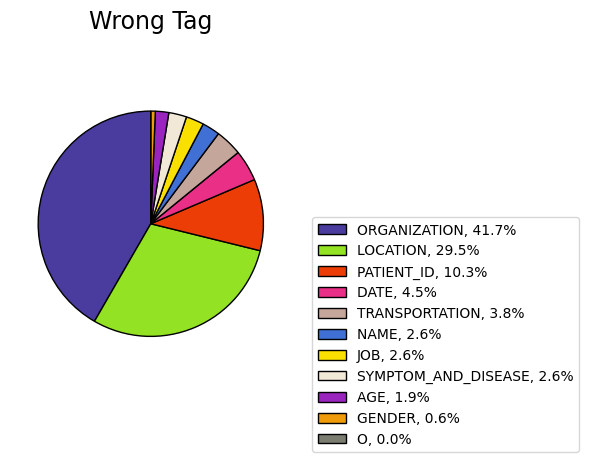

In [117]:
import matplotlib.patches

plt.gca().axis("equal")

temp_labels = df_wrongtag['Tag'].values.tolist()
pie = plt.pie(df_wrongtag.iloc[:, -1], startangle=90, wedgeprops={'linewidth': 1, "edgecolor": "k"}, colors=[colors[key] for key in temp_labels])
handles = []

for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i) / 8.), label=l))
plt.legend(labels, bbox_to_anchor=(1, 0), loc="lower right",
           bbox_transform=plt.gcf().transFigure)
plt.title("Wrong Tag", loc="center", fontsize=17)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.54)
plt.savefig('wrongtag.png', bbox_inches='tight', dpi=300)

# **WRONG RANGE**

In [118]:
df_wrongrange = df_final_bi[["Tag", "Wrong Range"]]
df_wrongrange

,Tag,Wrong Range
0,PATIENT_ID,17
1,NAME,4
2,AGE,4
3,GENDER,0
4,JOB,12
5,LOCATION,167
6,ORGANIZATION,32
7,SYMPTOM_AND_DISEASE,80
8,TRANSPORTATION,6
9,DATE,8


In [119]:
df_wrongrange = df_final_bi[["Tag", "Wrong Range"]]
df_wrongrange

# Add the following lines to calculate wrongrange_sum
df_wrongrange.sort_values("Wrong Range", ascending=False, inplace=True, ignore_index=True)
wrongrange_sum = df_wrongrange.iloc[0, -1]
df_wrongrange.drop(0, inplace=True)

labels = [f'{l}, {s * 100 / (wrongrange_sum):0.1f}%' for l, s in zip(df_wrongrange["Tag"], df_wrongrange["Wrong Range"])]
labels

<ipython-input-119-ca58f9398a21>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongrange.sort_values("Wrong Range", ascending=False, inplace=True, ignore_index=True)
<ipython-input-119-ca58f9398a21>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongrange.drop(0, inplace=True)


['LOCATION, 50.6%',
 'SYMPTOM_AND_DISEASE, 24.2%',
 'ORGANIZATION, 9.7%',
 'PATIENT_ID, 5.2%',
 'JOB, 3.6%',
 'DATE, 2.4%',
 'TRANSPORTATION, 1.8%',
 'NAME, 1.2%',
 'AGE, 1.2%',
 'GENDER, 0.0%',
 'O, 0.0%']

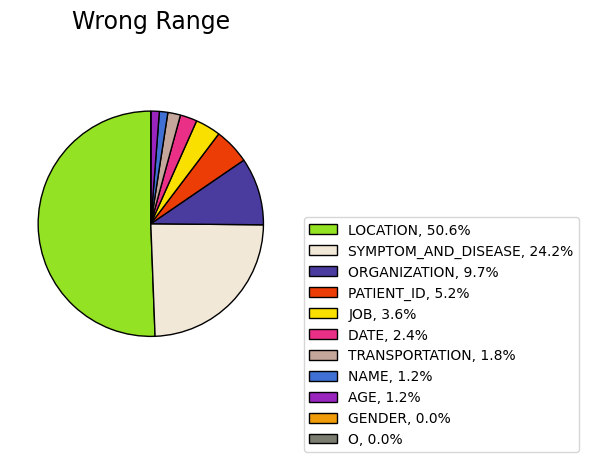

In [120]:
import matplotlib.patches

plt.gca().axis("equal")
temp_labels = df_wrongrange['Tag'].values.tolist()
pie = plt.pie(df_wrongrange.iloc[:, -1], startangle=90, wedgeprops={'linewidth': 1, "edgecolor": "k"}, colors=[colors[key] for key in temp_labels])
handles = []

for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i) / 8.), label=l))
plt.legend(labels, bbox_to_anchor=(1, 0), loc="lower right",
           bbox_transform=plt.gcf().transFigure)
plt.title("Wrong Range", loc="center", fontsize=17)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.54)
plt.savefig('wrongrange.png', bbox_inches='tight', dpi=300)

# **WRONG RANGE AND TAG**

In [121]:
df_wrongrange_tag = df_final_bi[["Tag", "Wrong Range and tag"]]
df_wrongrange_tag

,Tag,Wrong Range and tag
0,PATIENT_ID,3
1,NAME,7
2,AGE,1
3,GENDER,1
4,JOB,1
5,LOCATION,16
6,ORGANIZATION,22
7,SYMPTOM_AND_DISEASE,2
8,TRANSPORTATION,5
9,DATE,3


In [122]:
df_wrongrange_tag.sort_values("Wrong Range and tag", ascending=False, inplace=True, ignore_index=True)
wrongrange_tag_sum = df_wrongrange_tag.iloc[0, -1]
df_wrongrange_tag.drop(0, inplace=True)
df_wrongrange_tag

<ipython-input-122-aeebc9a7f01f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongrange_tag.sort_values("Wrong Range and tag", ascending=False, inplace=True, ignore_index=True)
<ipython-input-122-aeebc9a7f01f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongrange_tag.drop(0, inplace=True)


,Tag,Wrong Range and tag
1,ORGANIZATION,22
2,LOCATION,16
3,NAME,7
4,TRANSPORTATION,5
5,DATE,3
6,PATIENT_ID,3
7,SYMPTOM_AND_DISEASE,2
8,GENDER,1
9,AGE,1
10,JOB,1


In [123]:
labels = [f'{l}, {s * 100 / (wrongrange_tag_sum):0.1f}%' for l, s in zip(df_wrongrange_tag["Tag"], df_wrongrange_tag["Wrong Range and tag"])]
labels

['ORGANIZATION, 36.1%',
 'LOCATION, 26.2%',
 'NAME, 11.5%',
 'TRANSPORTATION, 8.2%',
 'DATE, 4.9%',
 'PATIENT_ID, 4.9%',
 'SYMPTOM_AND_DISEASE, 3.3%',
 'GENDER, 1.6%',
 'AGE, 1.6%',
 'JOB, 1.6%',
 'O, 0.0%']

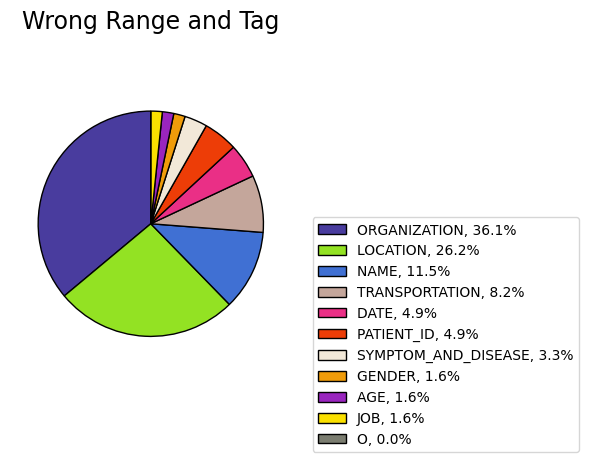

In [124]:
import matplotlib.patches

plt.gca().axis("equal")
temp_labels = df_wrongrange_tag['Tag'].values.tolist()
pie = plt.pie(df_wrongrange_tag.iloc[:, -1], startangle=90, wedgeprops={'linewidth': 1, "edgecolor": "k"}, colors=[colors[key] for key in temp_labels])
handles = []

for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i) / 8.), label=l))
plt.legend(labels, bbox_to_anchor=(1, 0), loc="lower right",
           bbox_transform=plt.gcf().transFigure)
plt.title("Wrong Range and Tag", loc="center", fontsize=17)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.54)
plt.savefig('wrongrange_tag.png', bbox_inches='tight', dpi=300)


# **PhoBERT**

In [125]:
class ErrorTypesGold:
    def __init__(self, tags_true, tags_pred, words_true, words_pred):
        self.result = {'No Extraction': [], 'No Annotation': [], 'Wrong Tag': [], 'Wrong Range': [], 'Wrong Range and tag': [], 'Num correct tags': []}
        self.tags_true = tags_true
        self.tags_pred = tags_pred
        self.words_true = words_true
        self.words_pred = words_pred
        self.spans_tags_true, self.spans_O_tags_true = self._get_span_of(tags_true)
        self.spans_tags_pred, self.spans_O_tags_pred = self._get_span_of(tags_pred)

    def _get_span_of(self, tags):
        entities = []
        single_entity = []

        for i, tag in enumerate(tags):
            if 'I-' in tag:
                single_entity.append(i)
            elif single_entity:
                if tag == 'O':
                    entities.append(single_entity)
                    single_entity = []
                elif 'B-' in tag:
                    entities.append(single_entity)
                    single_entity = [i]
            elif 'B-' in tag:
                single_entity.append(i)
        if single_entity:
            entities.append(single_entity)

        empty_spans = []
        empty_span = []

        for i, tag in enumerate(tags):
            if not empty_span and tag == 'O':
                empty_span.append(i)
            elif not any(x in tag for x in ['B-', 'I-']):
                empty_span.append(i)
            elif empty_span and any(x in tag for x in ['B-', 'I-']):

                empty_spans.append(empty_span)
                empty_span = []
        if empty_span:
            empty_spans.append(empty_span)

        return entities, empty_spans

    def _get_tags_true_in(self, span, exclude_o_tag=False):
        start, end = span[0], span[-1] + 1
        tags = self.tags_true[start: end]
        if exclude_o_tag:
            tags = list(set(word.replace('B-', '').replace('I-', '') for word in tags if word != 'O'))
        else:
            tags = list(set(word.replace('B-', '').replace('I-', '') for word in tags))
        return tags

    def _get_tags_pred_in(self, span, exclude_o_tag=False):
        start, end = span[0], span[-1] + 1
        tags = self.tags_pred[start: end]
        if exclude_o_tag:
            tags = list(set(word.replace('B-', '').replace('I-', '') for word in tags if word != 'O'))
        else:
            tags = list(set(word.replace('B-', '').replace('I-', '') for word in tags))
        return tags

    def _is_correct_range(self, span):
        return span in self.spans_tags_pred

    def _is_overlap(self, span, with_O_spans_tags_true=False):

        if not with_O_spans_tags_true:
            for that_span in self.spans_tags_pred:
                if len([bound for bound in span if bound in that_span]) == len(span):
                    return False
        else:
            for that_span in self.spans_O_tags_true:
                if len([bound for bound in span if bound in that_span]) == len(span):
                    return False

        return True

    def check(self):
        for span in self.spans_tags_true:
            start, end = span[0], span[-1] + 1
            tags_pred = self._get_tags_pred_in(span)
            tags_true = self._get_tags_true_in(span)
            raw_tag_true = self.tags_true[start: end]
            raw_tag_pred = self.tags_pred[start: end]
            raw_tag_true_to_end = self.tags_true[start:]
            raw_tag_pred_to_end = self.tags_pred[start:]
            raw_words = self.words_true[start: end]

            if self._is_correct_range(span):
                if tags_pred != tags_true:
                    self.result['Wrong Tag'].append((raw_tag_true, raw_tag_pred, raw_words))
                elif tags_pred == ['O'] * len(tags_pred):
                    self.result['No Extraction'].append((raw_tag_true, raw_tag_pred, raw_words))
                else:
                    self.result['Num correct tags'].append((raw_tag_true, raw_tag_pred, raw_words))
            else:
                if self._is_overlap(span):
                    if raw_tag_pred == ['O'] * len(raw_tag_pred):
                        self.result['No Extraction'].append((raw_tag_true, raw_tag_pred, raw_words))
                    elif tags_true[0] in tags_pred:
                        if 'O' in tags_pred:
                            self.result['Wrong Range'].append((raw_tag_true, raw_tag_pred, raw_words))
                        elif len([tag for tag in raw_tag_pred if 'B-' in tag]) != 1:
                            self.result['Wrong Range'].append((raw_tag_true, raw_tag_pred, raw_words))
                        elif len(raw_tag_pred) >= end + 1 and 'I-' in raw_tag_pred[end]:
                            self.result['Wrong Range'].append((raw_tag_true, raw_tag_pred, raw_words))

                    else:
                        self.result['Wrong Range and tag'].append((raw_tag_true, raw_tag_pred, raw_words))  # print(raw_tag_true, raw_tag_pred, raw_words, sep='\n')  # print(raw_tag_true_to_end)  # print(raw_tag_pred_to_end)  # print('---------------')

                else:
                    if len([tag for tag in raw_tag_pred if 'B-' in tag]) != 1:
                        if tags_true[0] in tags_pred:
                            self.result['Wrong Range'].append((raw_tag_true, raw_tag_pred, raw_words))
                        else:
                            self.result['Wrong Range and tag'].append((raw_tag_true, raw_tag_pred, raw_words))  # print(raw_tag_true, raw_tag_pred, raw_words, sep='\n')  # print(raw_tag_true_to_end)  # print(raw_tag_pred_to_end)  # print('---------------')
                    else:
                        self.result['Num correct tags'].append((raw_tag_true, raw_tag_pred, raw_words))

        for span in self.spans_tags_pred:
            start, end = span[0], span[-1] + 1
            tags_pred = self._get_tags_pred_in(span)
            tags_true = self._get_tags_true_in(span)
            raw_tag_true = self.tags_true[start: end]
            raw_tag_pred = self.tags_pred[start: end]
            raw_words = self.words_true[start: end]
            if not self._is_overlap(span, with_O_spans_tags_true=True):
                self.result['No Annotation'].append((raw_tag_true, raw_tag_pred, raw_words))

        return self


all_words_true, all_tags_true = load_dataset(r'/content/drive/MyDrive/NLP project/Error Analysis/phoBERT analysis/test_true_PhoBERT.txt')
unique_tags = get_unique_tags(r'/content/drive/MyDrive/NLP project/Error Analysis/phoBERT analysis/test_true_PhoBERT.txt')
all_words_pred, all_tags_pred = load_dataset(r'/content/drive/MyDrive/NLP project/Error Analysis/phoBERT analysis/test_predictions_PhoBERT.txt')

errors = ['No Extraction', 'No Annotation', 'Wrong Range', 'Wrong Tag', 'Wrong Range and tag', 'Num correct tags']
df = pd.DataFrame(columns=errors)

for i, (tags_true, tags_pred, words_true, words_pred) in enumerate(zip(all_tags_true, all_tags_pred, all_words_true, all_words_pred)):
    error_types = ErrorTypesGold(tags_true, tags_pred, words_true, words_pred).check()
    df = pd.concat([df, pd.DataFrame([error_types.result])])

df.reset_index(drop=True, inplace=True)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Row'}, inplace=True)
df = pd.concat([df, pd.DataFrame(data={'Sentence': all_words_true})], axis=1)
df.to_csv('/content/drive/MyDrive/NLP project/Error Analysis/phoBERT analysis/df_error_types_phoBERT_gold.csv', index=False)

# print summary
for column in df.columns:
    if column in ['Num correct tags', 'Row']:
        continue
    print(column)
    print(df[column].apply(lambda x: len(x) if x else False).sum())

##
df_new = df.iloc[:, :-1].copy()

for error in errors:
    df_new[error] = df_new[error].map(convert_cell_to_tag)

##
# Tao df moi
unique_tags = ['PATIENT_ID', 'NAME', 'AGE', 'GENDER', 'JOB', 'LOCATION', 'ORGANIZATION', 'SYMPTOM_AND_DISEASE', 'TRANSPORTATION', 'DATE', 'O']

df2 = pd.DataFrame(columns=errors)
for tag in unique_tags:
    counts = {}
    for error in errors:
        count_tag = lambda x: len([tag_inside for tag_inside in x if tag_inside == tag])
        temp = df_new[error]
        counts[error] = temp.map(count_tag).sum()
    df2 = pd.concat([df2, pd.DataFrame(data=counts, index=[0])])
# count tung truong hop roi gan do df moi

df2.reset_index(drop=True, inplace=True)
df2 = pd.concat([pd.DataFrame(data={'Tag': unique_tags}), df2], axis=1)

# Tạo cột Errors
num_errors = []
for tag in unique_tags:
    num_errors.append(df2[df2['Tag'] == tag].iloc[:, 1:-1].sum().sum())
df2 = pd.concat([pd.DataFrame(data={'Errors': num_errors}), df2], axis=1)

# tạo cột total
totals = []
for tag in unique_tags:
    totals.append(df2[df2['Tag'] == tag].iloc[:, 2:].sum().sum())
df2 = pd.concat([pd.DataFrame(data={'Total': totals}), df2], axis=1)

# Sắp xếp lại
df2 = df2[['Tag', 'Total', 'Errors', 'No Extraction', 'No Annotation', 'Wrong Range', 'Wrong Tag', 'Wrong Range and tag']]

# Tạo hàng Total
total_row = df2.sum(axis=0).to_dict()
total_row['Tag'] = 'Total'
df2 = pd.concat([df2, pd.DataFrame(total_row, index=[0])])

df2.to_csv('/content/drive/MyDrive/NLP project/Error Analysis/phoBERT analysis/df_error_types_phobert_gold_summary.csv', index=False)  ##

No Extraction
138
No Annotation
172
Wrong Range
246
Wrong Tag
92
Wrong Range and tag
19
Sentence
85678


In [150]:
df_final = pd.read_csv("/content/drive/MyDrive/NLP project/Error Analysis/phoBERT analysis/df_error_types_phobert_gold_summary.csv")

colors_error_types = {'Wrong Range': 'C0',
                      'No Extraction': 'C1',
                      'Wrong Tag': 'C2',
                      'Wrong Range and tag': 'C3',
                      'No Annotation': 'C4'
                      }

colors = {
        'DATE': '#EA2F86',  # https://www.schemecolor.com/bright-rainbow-gradient.php
        'GENDER': '#F09C0A',
        'JOB': '#FAE000',
        'LOCATION': '#93E223',
        'NAME': '#4070D3',
        'AGE': '#9925be',
        'O': '#7B7D70',  # màu gray ở https://www.schemecolor.com/rural-stay.php
        'ORGANIZATION': '#493C9E',
        'PATIENT_ID': '#ED3D07',  # màu đỏ https://www.schemecolor.com/bright-summer-beach.php
        'SYMPTOM_AND_DISEASE': '#F2E8D8',  # https://www.schemecolor.com/pastels-for-men.php
        'TRANSPORTATION': '#C4A69B'}


In [151]:
df_final

,Tag,Total,Errors,No Extraction,No Annotation,Wrong Range,Wrong Tag,Wrong Range and tag
0,PATIENT_ID,2005,29,4,0,21,4,0
1,NAME,318,18,14,0,3,1,0
2,AGE,582,20,9,0,6,3,2
3,GENDER,462,8,6,0,0,2,0
4,JOB,173,31,18,0,11,2,0
5,LOCATION,4441,188,25,0,117,39,7
6,ORGANIZATION,771,71,14,0,12,36,9
7,SYMPTOM_AND_DISEASE,1136,115,43,0,71,0,1
8,TRANSPORTATION,193,2,0,0,1,1,0
9,DATE,1654,13,5,0,4,4,0


In [152]:
df_all = df_final.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [155]:
df_all

,Tag,Total,Errors,No Extraction,No Annotation,Wrong Range,Wrong Tag,Wrong Range and tag
11,Total,11907,667,138,172,246,92,19


In [154]:
name = pd.Series(["No Extraction", "Wrong Range", "No Annotation", "Wrong Tag", "Wrong Range and tag"])
value = pd.Series([169, 290, 237, 94, 17])

In [131]:
labels = [f'{l}, {s * 100 / (1134):0.1f}%' for l, s in zip(name, value)]

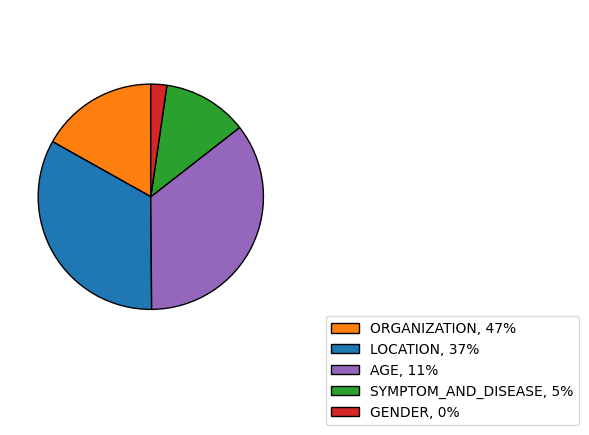

In [156]:
import matplotlib.patches

label = name.values.tolist()
plt.gca().axis("equal")
pie = plt.pie([140, 276, 294, 101, 19], startangle=90, wedgeprops={'linewidth': 1, "edgecolor": "k"}, colors=[colors_error_types[key] for key in label])
handles = []

for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i) / 8.), label=l))
plt.legend(labels, bbox_to_anchor=(1, 0), loc="lower right",
           bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.54)
plt.savefig('all_error_Bi.png', bbox_inches='tight', dpi=300)

# **NO EXTRACTION**

In [157]:
df_noex = df_final[["Tag", "No Extraction"]]
df_noex

,Tag,No Extraction
0,PATIENT_ID,4
1,NAME,14
2,AGE,9
3,GENDER,6
4,JOB,18
5,LOCATION,25
6,ORGANIZATION,14
7,SYMPTOM_AND_DISEASE,43
8,TRANSPORTATION,0
9,DATE,5


In [158]:
df_noex.sort_values("No Extraction", ascending=False, inplace=True, ignore_index=True)
no_ex_sum = df_noex.iloc[0, -1]
df_noex.drop(0, inplace=True)
df_noex

<ipython-input-158-e5404dd78659>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noex.sort_values("No Extraction", ascending=False, inplace=True, ignore_index=True)
<ipython-input-158-e5404dd78659>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noex.drop(0, inplace=True)


,Tag,No Extraction
1,SYMPTOM_AND_DISEASE,43
2,LOCATION,25
3,JOB,18
4,ORGANIZATION,14
5,NAME,14
6,AGE,9
7,GENDER,6
8,DATE,5
9,PATIENT_ID,4
10,TRANSPORTATION,0


In [159]:
labels = [f'{l}, {s * 100 / (no_ex_sum):0.1f}%' for l, s in zip(df_noex["Tag"], df_noex["No Extraction"])]
labels

['SYMPTOM_AND_DISEASE, 31.2%',
 'LOCATION, 18.1%',
 'JOB, 13.0%',
 'ORGANIZATION, 10.1%',
 'NAME, 10.1%',
 'AGE, 6.5%',
 'GENDER, 4.3%',
 'DATE, 3.6%',
 'PATIENT_ID, 2.9%',
 'TRANSPORTATION, 0.0%',
 'O, 0.0%']

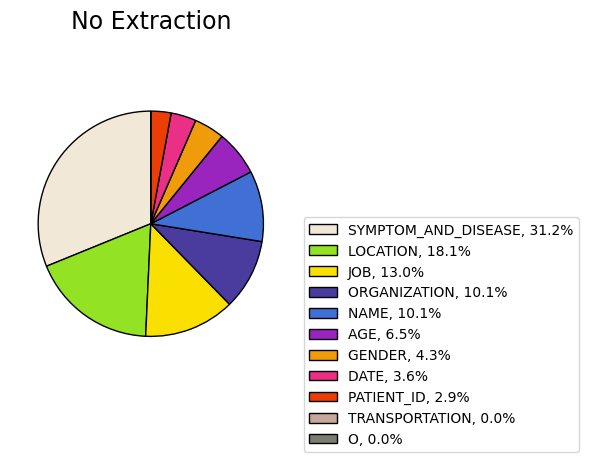

In [160]:
import matplotlib.patches

plt.gca().axis("equal")

temp_labels = df_noex['Tag'].values.tolist()
pie = plt.pie(df_noex["No Extraction"], startangle=90, wedgeprops={'linewidth': 1, "edgecolor": "k"}, colors=[colors[key] for key in temp_labels])
handles = []

for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i) / 8.), label=l))
plt.legend(labels, bbox_to_anchor=(1, 0), loc="lower right",
           bbox_transform=plt.gcf().transFigure)
plt.title("No Extraction", loc="center", fontsize=17)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.54)
plt.savefig('no_extraction.png', bbox_inches='tight', dpi=300)

# **WRONG TAG**

In [162]:
df_wrongtag = df_final[["Tag", "Wrong Tag"]]
df_wrongtag

,Tag,Wrong Tag
0,PATIENT_ID,4
1,NAME,1
2,AGE,3
3,GENDER,2
4,JOB,2
5,LOCATION,39
6,ORGANIZATION,36
7,SYMPTOM_AND_DISEASE,0
8,TRANSPORTATION,1
9,DATE,4


In [138]:
df_wrongtag.sort_values("Wrong Tag", ascending=False, inplace=True, ignore_index=True)
wrongtag_sum = df_wrongtag.iloc[0, -1]
df_wrongtag.drop(0, inplace=True)
df_wrongtag

<ipython-input-138-cadf118d5ff5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongtag.sort_values("Wrong Tag", ascending=False, inplace=True, ignore_index=True)
<ipython-input-138-cadf118d5ff5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongtag.drop(0, inplace=True)


,Tag,Wrong Tag
1,LOCATION,39
2,ORGANIZATION,36
3,PATIENT_ID,4
4,DATE,4
5,AGE,3
6,JOB,2
7,GENDER,2
8,NAME,1
9,TRANSPORTATION,1
10,SYMPTOM_AND_DISEASE,0


In [139]:
labels = [f'{l}, {s * 100 / (wrongtag_sum):0.1f}%' for l, s in zip(df_wrongtag["Tag"], df_wrongtag["Wrong Tag"])]
labels

['LOCATION, 42.4%',
 'ORGANIZATION, 39.1%',
 'PATIENT_ID, 4.3%',
 'DATE, 4.3%',
 'AGE, 3.3%',
 'JOB, 2.2%',
 'GENDER, 2.2%',
 'NAME, 1.1%',
 'TRANSPORTATION, 1.1%',
 'SYMPTOM_AND_DISEASE, 0.0%',
 'O, 0.0%']

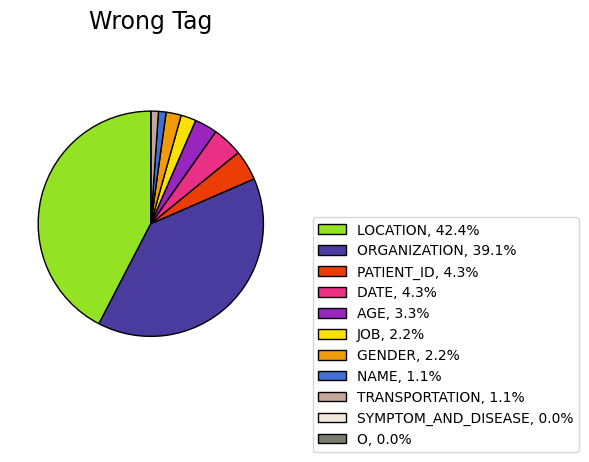

In [140]:
import matplotlib.patches

plt.gca().axis("equal")

temp_labels = df_wrongtag['Tag'].values.tolist()
pie = plt.pie(df_wrongtag.iloc[:, -1], startangle=90, wedgeprops={'linewidth': 1, "edgecolor": "k"}, colors=[colors[key] for key in temp_labels])
handles = []

for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i) / 8.), label=l))
plt.legend(labels, bbox_to_anchor=(1, 0), loc="lower right",
           bbox_transform=plt.gcf().transFigure)
plt.title("Wrong Tag", loc="center", fontsize=17)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.54)
plt.savefig('wrongtag.png', bbox_inches='tight', dpi=300)

# **WRONG RANGE**

In [141]:
df_wrongrange = df_final[["Tag", "Wrong Range"]]
df_wrongrange

,Tag,Wrong Range
0,PATIENT_ID,21
1,NAME,3
2,AGE,6
3,GENDER,0
4,JOB,11
5,LOCATION,117
6,ORGANIZATION,12
7,SYMPTOM_AND_DISEASE,71
8,TRANSPORTATION,1
9,DATE,4


In [142]:
df_wrongrange.sort_values("Wrong Range", ascending=False, inplace=True, ignore_index=True)
wrongrange_sum = df_wrongrange.iloc[0, -1]
df_wrongrange.drop(0, inplace=True)
df_wrongrange

<ipython-input-142-a247bd301243>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongrange.sort_values("Wrong Range", ascending=False, inplace=True, ignore_index=True)
<ipython-input-142-a247bd301243>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongrange.drop(0, inplace=True)


,Tag,Wrong Range
1,LOCATION,117
2,SYMPTOM_AND_DISEASE,71
3,PATIENT_ID,21
4,ORGANIZATION,12
5,JOB,11
6,AGE,6
7,DATE,4
8,NAME,3
9,TRANSPORTATION,1
10,GENDER,0


In [143]:
labels = [f'{l}, {s * 100 / (wrongrange_sum):0.1f}%' for l, s in zip(df_wrongrange["Tag"], df_wrongrange["Wrong Range"])]
labels

['LOCATION, 47.6%',
 'SYMPTOM_AND_DISEASE, 28.9%',
 'PATIENT_ID, 8.5%',
 'ORGANIZATION, 4.9%',
 'JOB, 4.5%',
 'AGE, 2.4%',
 'DATE, 1.6%',
 'NAME, 1.2%',
 'TRANSPORTATION, 0.4%',
 'GENDER, 0.0%',
 'O, 0.0%']

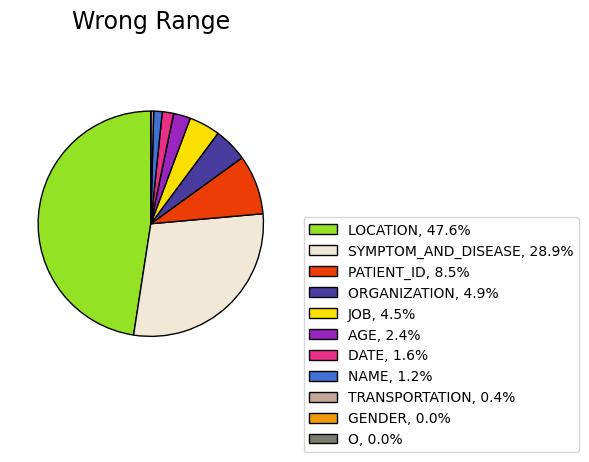

In [144]:
import matplotlib.patches

plt.gca().axis("equal")
temp_labels = df_wrongrange['Tag'].values.tolist()
pie = plt.pie(df_wrongrange.iloc[:, -1], startangle=90, wedgeprops={'linewidth': 1, "edgecolor": "k"}, colors=[colors[key] for key in temp_labels])
handles = []

for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i) / 8.), label=l))
plt.legend(labels, bbox_to_anchor=(1, 0), loc="lower right",
           bbox_transform=plt.gcf().transFigure)
plt.title("Wrong Range", loc="center", fontsize=17)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.54)
plt.savefig('wrongrange.png', bbox_inches='tight', dpi=300)

# **WRONG RANGE AND TAG**

In [145]:
df_wrongrange_tag = df_final[["Tag", "Wrong Range and tag"]]
df_wrongrange_tag

,Tag,Wrong Range and tag
0,PATIENT_ID,0
1,NAME,0
2,AGE,2
3,GENDER,0
4,JOB,0
5,LOCATION,7
6,ORGANIZATION,9
7,SYMPTOM_AND_DISEASE,1
8,TRANSPORTATION,0
9,DATE,0


In [146]:
df_wrongrange_tag.sort_values("Wrong Range and tag", ascending=False, inplace=True, ignore_index=True)
wrongrange_tag = df_wrongrange_tag.iloc[0, -1]
df_wrongrange_tag.drop(0, inplace=True)
df_wrongrange_tag

<ipython-input-146-c6d666124aef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongrange_tag.sort_values("Wrong Range and tag", ascending=False, inplace=True, ignore_index=True)
<ipython-input-146-c6d666124aef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongrange_tag.drop(0, inplace=True)


,Tag,Wrong Range and tag
1,ORGANIZATION,9
2,LOCATION,7
3,AGE,2
4,SYMPTOM_AND_DISEASE,1
5,GENDER,0
6,PATIENT_ID,0
7,NAME,0
8,JOB,0
9,TRANSPORTATION,0
10,DATE,0


In [147]:
df_wrongrange_tag = df_final[["Tag", "Wrong Range and tag"]]
df_wrongrange_tag

# Add the following lines to calculate wrongrange_sum
df_wrongrange_tag.sort_values("Wrong Range and tag", ascending=False, inplace=True, ignore_index=True)
wrongrange_tag_sum = df_wrongrange_tag.iloc[0, -1]
df_wrongrange_tag.drop(0, inplace=True)

labels = [f'{l}, {s * 100 / (wrongrange_tag_sum):0.0f}%' for l, s in zip(df_wrongrange_tag["Tag"], df_wrongrange_tag["Wrong Range and tag"])]
labels

<ipython-input-147-d63d8b7015f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongrange_tag.sort_values("Wrong Range and tag", ascending=False, inplace=True, ignore_index=True)
<ipython-input-147-d63d8b7015f1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrongrange_tag.drop(0, inplace=True)


['ORGANIZATION, 47%',
 'LOCATION, 37%',
 'AGE, 11%',
 'SYMPTOM_AND_DISEASE, 5%',
 'GENDER, 0%',
 'PATIENT_ID, 0%',
 'NAME, 0%',
 'JOB, 0%',
 'TRANSPORTATION, 0%',
 'DATE, 0%',
 'O, 0%']

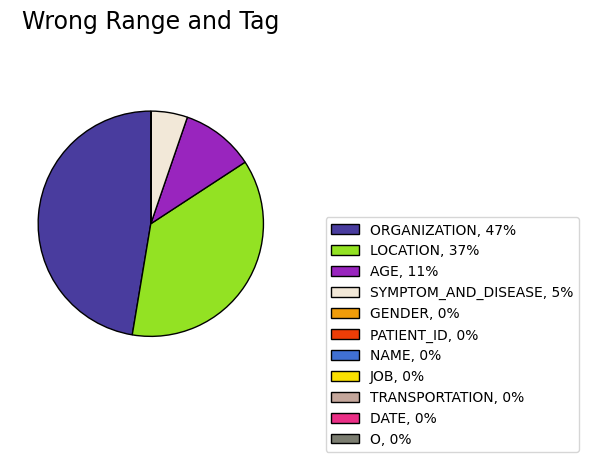

In [148]:
import matplotlib.patches

plt.gca().axis("equal")
temp_labels = df_wrongrange_tag['Tag'].values.tolist()
pie = plt.pie(df_wrongrange_tag.iloc[:, -1], startangle=90, wedgeprops={'linewidth': 1, "edgecolor": "k"}, colors=[colors[key] for key in temp_labels])
handles = []

for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i) / 8.), label=l))
plt.legend(labels, bbox_to_anchor=(1, 0), loc="lower right",
           bbox_transform=plt.gcf().transFigure)
plt.title("Wrong Range and Tag", loc="center", fontsize=17)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.54)
plt.savefig('wrongrange_tag.png', bbox_inches='tight', dpi=300)